# AnnoMI Full Dataset - Enhanced Analysis

This notebook analyzes the **full AnnoMI dataset** with additional annotation details, building on insights from previous analyses.

**Dataset:** `AnnoMI-full.csv` (using first annotation per utterance)

**Key Features:**
- ✅ Rich annotation data (therapist input subtypes, reflection types, question types)
- ✅ Cognitive action predictions integrated
- ✅ Advanced sequential pattern analysis
- ✅ Annotation subtype correlation with cognitive actions
- ✅ Multi-modal therapeutic strategy analysis

**Analyses:**
1. 🎯 **Annotation Subtype Analysis** - Deep dive into reflection/question/input types
2. 🔄 **Cognitive-Behavioral Correlation** - How cognitive actions relate to therapist behaviors
3. 📊 **Multi-dimensional Pattern Mining** - Combined annotation + cognitive patterns
4. 🎭 **Therapeutic Strategy Profiling** - Identify distinct therapeutic approaches
5. 🔗 **Cross-modal Transition Analysis** - How behaviors and cognition flow together

## 1️⃣ Setup and Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# Load the full AnnoMI dataset
print("📥 Loading AnnoMI-full.csv...")
df_full = pd.read_csv('third_party/AnnoMI/AnnoMI-full.csv')

print(f"✅ Loaded {len(df_full)} rows")
print(f"   Unique utterances: {df_full.groupby(['transcript_id', 'utterance_id']).ngroups}")
print(f"   Annotators: {df_full['annotator_id'].nunique()}")

# Take first annotation per utterance
print("\n🔧 Selecting first annotation per utterance...")
df = df_full.groupby(['transcript_id', 'utterance_id']).first().reset_index()

print(f"✅ Dataset reduced to {len(df)} utterances (one per unique utterance)")
print(f"\n📊 Dataset Overview:")
print(f"   Transcripts: {df['transcript_id'].nunique()}")
print(f"   Topics: {df['topic'].nunique()}")
print(f"   Therapist utterances: {len(df[df['interlocutor'] == 'therapist'])}")
print(f"   Client utterances: {len(df[df['interlocutor'] == 'client'])}")

📥 Loading AnnoMI-full.csv...
✅ Loaded 13551 rows
   Unique utterances: 9699
   Annotators: 10

🔧 Selecting first annotation per utterance...
✅ Dataset reduced to 9699 utterances (one per unique utterance)

📊 Dataset Overview:
   Transcripts: 133
   Topics: 44
   Therapist utterances: 4882
   Client utterances: 4817


In [3]:
# Load cognitive action predictions
print("📥 Loading cognitive action predictions...")
with open('output/analysis_AnnoMI/all_predictions.json', 'r') as f:
    all_predictions = json.load(f)

print(f"✅ Loaded {len(all_predictions)} predictions")

# Create predictions DataFrame
df_predictions = pd.DataFrame(all_predictions)

# Merge with annotations
print("\n🔗 Merging annotations with cognitive predictions...")
df_merged = df.merge(
    df_predictions[['transcript_id', 'utterance_id', 'predictions', 'action_layer_details']],
    on=['transcript_id', 'utterance_id'],
    how='left'
)

print(f"✅ Merged dataset: {len(df_merged)} utterances")
print(f"   With predictions: {df_merged['predictions'].notna().sum()}")
print(f"   Without predictions: {df_merged['predictions'].isna().sum()}")

📥 Loading cognitive action predictions...
✅ Loaded 9699 predictions

🔗 Merging annotations with cognitive predictions...
✅ Merged dataset: 9699 utterances
   With predictions: 9699
   Without predictions: 0


## 2️⃣ Data Preparation & Filtering

In [4]:
# Filter short utterances and apply high-confidence action filtering
MIN_LENGTH = 10
df_merged['utterance_length'] = df_merged['utterance_text'].str.len()
df_work = df_merged[df_merged['utterance_length'] >= MIN_LENGTH].copy()

print(f"🔄 Filtering utterances < {MIN_LENGTH} characters...")
print(f"   Before: {len(df_merged)} utterances")
print(f"   After: {len(df_work)} utterances")
print(f"   Removed: {len(df_merged) - len(df_work)} ({(len(df_merged) - len(df_work))/len(df_merged)*100:.1f}%)")

# Extract active cognitive actions with high-confidence filtering
def extract_active_actions_filtered(row):
    """Extract high-confidence active cognitive actions"""
    if pd.isna(row['predictions']):
        return []
    
    predictions = row['predictions']
    action_layer_details = row.get('action_layer_details', {})
    
    active = []
    for action, data in predictions.items():
        if not data.get('is_active', False):
            continue
        
        # High-confidence filter: >2 layers OR 100% confidence
        num_layers = len(action_layer_details.get(action, []))
        max_confidence = max(
            [layer_info['confidence'] for layer_info in action_layer_details.get(action, [])],
            default=0
        )
        
        if num_layers > 2 or max_confidence >= 1.0:
            active.append({
                'action': action,
                'confidence': data['aggregate'],
                'best_layer': data['best_layer'],
                'num_layers': num_layers
            })
    return active

df_work['active_actions'] = df_work.apply(extract_active_actions_filtered, axis=1)
df_work['num_active_actions'] = df_work['active_actions'].apply(len)
df_work['action_names'] = df_work['active_actions'].apply(
    lambda x: [a['action'] for a in x]
)

print(f"\n🧠 Cognitive Actions Statistics:")
print(f"   Mean actions per utterance: {df_work['num_active_actions'].mean():.2f}")
print(f"   Median actions per utterance: {df_work['num_active_actions'].median():.1f}")
print(f"   Utterances with actions: {len(df_work[df_work['num_active_actions'] > 0])} ({len(df_work[df_work['num_active_actions'] > 0])/len(df_work)*100:.1f}%)")

🔄 Filtering utterances < 10 characters...
   Before: 9699 utterances
   After: 7372 utterances
   Removed: 2327 (24.0%)

🧠 Cognitive Actions Statistics:
   Mean actions per utterance: 4.09
   Median actions per utterance: 4.0
   Utterances with actions: 7293 (98.9%)


## 3️⃣ Analysis 1: Annotation Subtype Deep Dive

Analyze the detailed annotation subtypes available in the full dataset:
- Therapist input subtypes (giving information, warning, etc.)
- Reflection subtypes (simple vs complex)
- Question subtypes (open vs closed)

In [5]:
print("="*80)
print("ANNOTATION SUBTYPE ANALYSIS")
print("="*80)

therapist_df = df_work[df_work['interlocutor'] == 'therapist'].copy()

# 1. Therapist Input Subtypes
print("\n" + "="*80)
print("THERAPIST INPUT SUBTYPES")
print("="*80)

input_subtypes = therapist_df[
    therapist_df['therapist_input_exists'] == True
]['therapist_input_subtype'].value_counts()

for subtype, count in input_subtypes.items():
    pct = count / len(therapist_df) * 100
    print(f"   {subtype:20s}: {count:4d} ({pct:5.1f}%)")

# 2. Reflection Subtypes
print("\n" + "="*80)
print("REFLECTION SUBTYPES")
print("="*80)

reflection_subtypes = therapist_df[
    therapist_df['reflection_exists'] == True
]['reflection_subtype'].value_counts()

for subtype, count in reflection_subtypes.items():
    pct = count / len(therapist_df) * 100
    print(f"   {subtype:20s}: {count:4d} ({pct:5.1f}%)")

# 3. Question Subtypes
print("\n" + "="*80)
print("QUESTION SUBTYPES")
print("="*80)

question_subtypes = therapist_df[
    therapist_df['question_exists'] == True
]['question_subtype'].value_counts()

for subtype, count in question_subtypes.items():
    pct = count / len(therapist_df) * 100
    print(f"   {subtype:20s}: {count:4d} ({pct:5.1f}%)")

ANNOTATION SUBTYPE ANALYSIS

THERAPIST INPUT SUBTYPES
   information         :  439 ( 11.7%)
   advice              :  144 (  3.8%)
   negotiation         :  132 (  3.5%)
   options             :   44 (  1.2%)

REFLECTION SUBTYPES
   simple              :  781 ( 20.8%)
   complex             :  691 ( 18.4%)

QUESTION SUBTYPES
   open                :  934 ( 24.9%)
   closed              :  665 ( 17.7%)


## 4️⃣ Analysis 2: Cognitive-Behavioral Correlation

Correlate cognitive actions with specific annotation subtypes

In [6]:
print("="*80)
print("COGNITIVE ACTIONS BY ANNOTATION SUBTYPE")
print("="*80)

def get_top_actions_for_subtype(df, column, value, top_n=10):
    """Get top cognitive actions for a specific annotation subtype"""
    subset = df[df[column] == value]
    actions = Counter()
    
    for _, row in subset.iterrows():
        for action_data in row['active_actions']:
            actions[action_data['action']] += action_data['confidence']
    
    return actions.most_common(top_n)

# Analyze reflection subtypes
print("\n" + "="*80)
print("SIMPLE REFLECTIONS - Top 10 Cognitive Actions")
print("="*80)
simple_ref = get_top_actions_for_subtype(
    therapist_df, 'reflection_subtype', 'simple'
)
for action, score in simple_ref:
    print(f"   {action:35s} {score:7.2f}")

print("\n" + "="*80)
print("COMPLEX REFLECTIONS - Top 10 Cognitive Actions")
print("="*80)
complex_ref = get_top_actions_for_subtype(
    therapist_df, 'reflection_subtype', 'complex'
)
for action, score in complex_ref:
    print(f"   {action:35s} {score:7.2f}")

# Analyze question subtypes
print("\n" + "="*80)
print("OPEN QUESTIONS - Top 10 Cognitive Actions")
print("="*80)
open_q = get_top_actions_for_subtype(
    therapist_df, 'question_subtype', 'open'
)
for action, score in open_q:
    print(f"   {action:35s} {score:7.2f}")

print("\n" + "="*80)
print("CLOSED QUESTIONS - Top 10 Cognitive Actions")
print("="*80)
closed_q = get_top_actions_for_subtype(
    therapist_df, 'question_subtype', 'closed'
)
for action, score in closed_q:
    print(f"   {action:35s} {score:7.2f}")

COGNITIVE ACTIONS BY ANNOTATION SUBTYPE

SIMPLE REFLECTIONS - Top 10 Cognitive Actions
   noticing                             391.27
   self_questioning                     213.14
   response_modulation                  202.14
   emotion_understanding                173.34
   analogical_thinking                  161.52
   abstracting                          153.89
   reframing                            145.56
   questioning                          134.40
   convergent_thinking                  130.91
   divergent_thinking                   116.27

COMPLEX REFLECTIONS - Top 10 Cognitive Actions
   noticing                             304.33
   emotion_understanding                165.19
   response_modulation                  164.59
   self_questioning                     153.52
   analogical_thinking                  141.00
   questioning                          126.96
   reframing                            111.99
   abstracting                          105.64
   distinguishing  

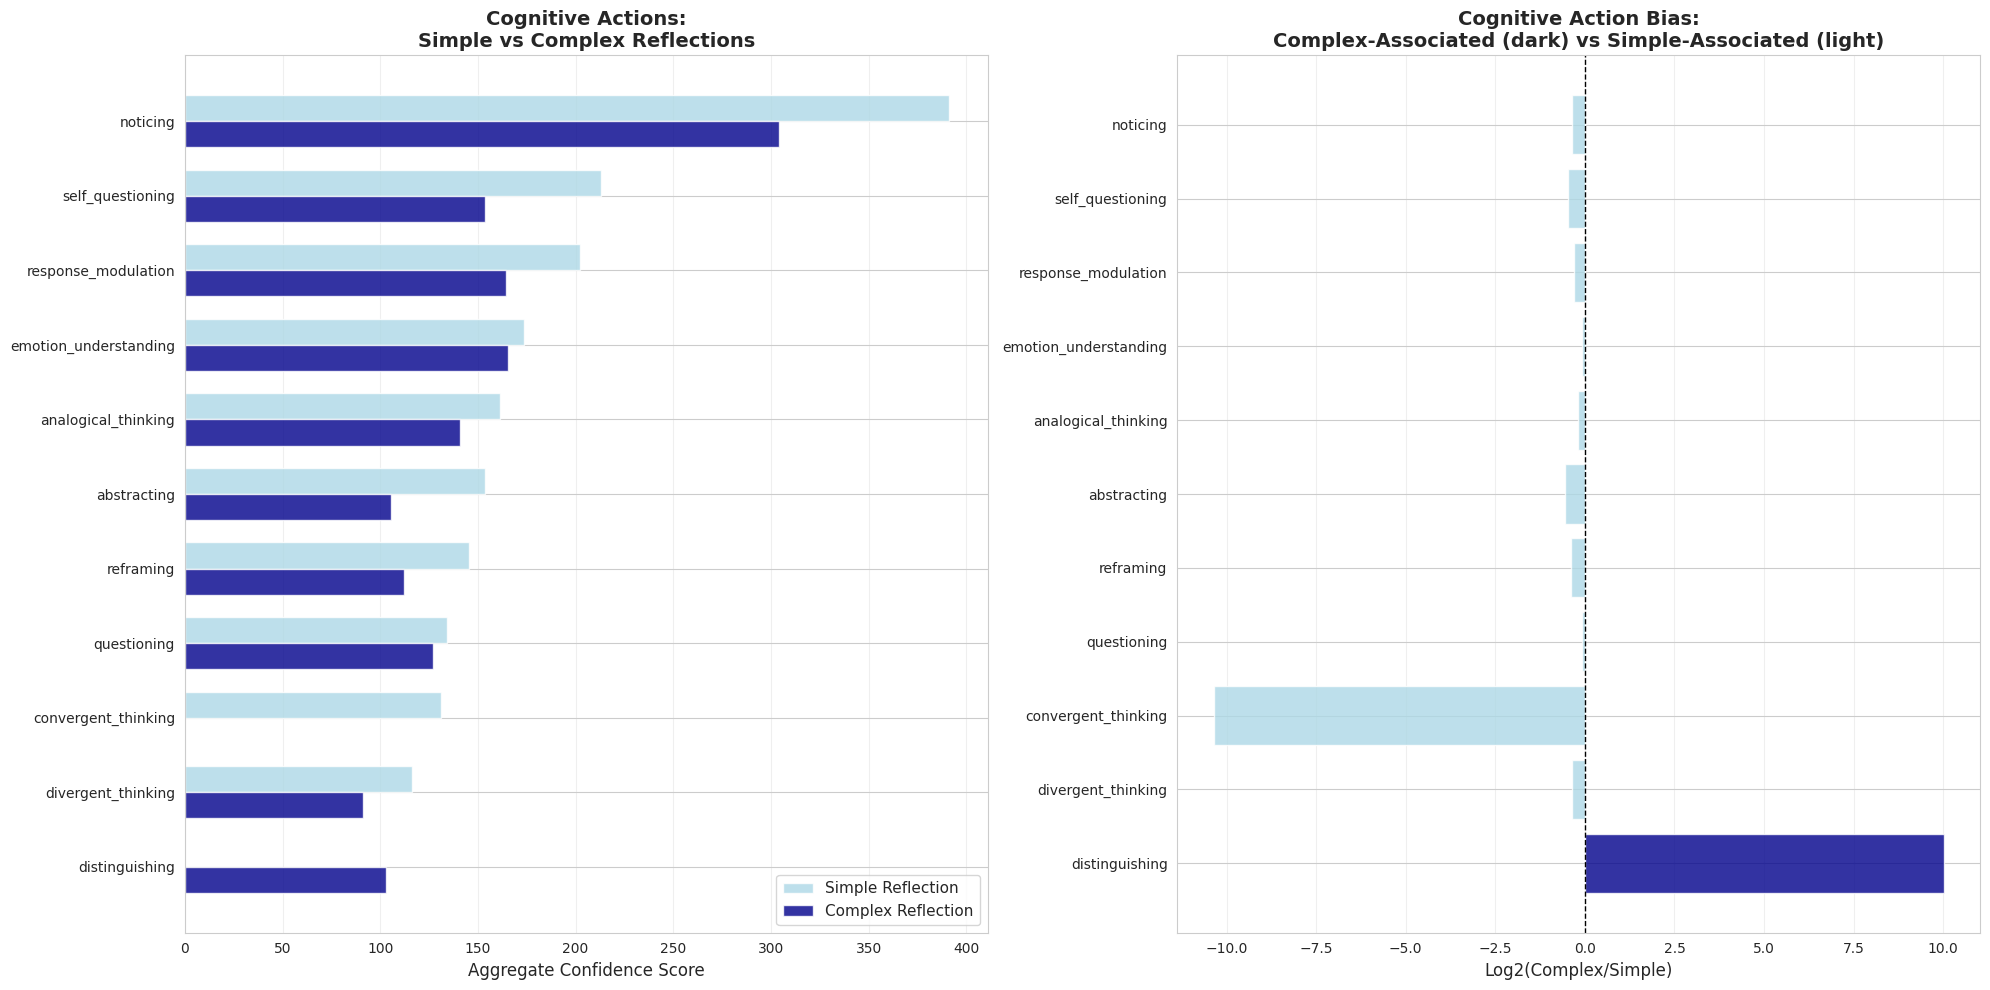

✅ Visualization saved: output/analysis_AnnoMI/full_viz_1_reflection_types.png


In [7]:
# Visualize reflection type comparison
simple_dict = dict(simple_ref)
complex_dict = dict(complex_ref)

all_ref_actions = sorted(
    set(list(simple_dict.keys()) + list(complex_dict.keys())),
    key=lambda x: max(simple_dict.get(x, 0), complex_dict.get(x, 0)),
    reverse=True
)

simple_scores = [simple_dict.get(a, 0) for a in all_ref_actions]
complex_scores = [complex_dict.get(a, 0) for a in all_ref_actions]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Comparison
x = np.arange(len(all_ref_actions))
width = 0.35

axes[0].barh(x - width/2, simple_scores, width, label='Simple Reflection', 
             color='lightblue', alpha=0.8)
axes[0].barh(x + width/2, complex_scores, width, label='Complex Reflection', 
             color='darkblue', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(all_ref_actions, fontsize=10)
axes[0].set_xlabel('Aggregate Confidence Score', fontsize=12)
axes[0].set_title('Cognitive Actions:\nSimple vs Complex Reflections', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Plot 2: Ratio
ratios = []
for action in all_ref_actions:
    s = simple_dict.get(action, 0.1)
    c = complex_dict.get(action, 0.1)
    ratio = np.log2(c / s)
    ratios.append(ratio)

colors = ['darkblue' if r > 0 else 'lightblue' for r in ratios]
axes[1].barh(range(len(all_ref_actions)), ratios, color=colors, alpha=0.8)
axes[1].set_yticks(range(len(all_ref_actions)))
axes[1].set_yticklabels(all_ref_actions, fontsize=10)
axes[1].set_xlabel('Log2(Complex/Simple)', fontsize=12)
axes[1].set_title('Cognitive Action Bias:\nComplex-Associated (dark) vs Simple-Associated (light)',
                  fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/full_viz_1_reflection_types.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/full_viz_1_reflection_types.png")

## 5️⃣ Analysis 3: Multi-dimensional Pattern Mining

Find patterns that combine:
- Annotation type (reflection/question/input)
- Annotation subtype
- Cognitive action patterns
- MI quality

In [8]:
print("="*80)
print("MULTI-DIMENSIONAL PATTERN ANALYSIS")
print("="*80)

# Create multi-dimensional patterns
def create_pattern_signature(row):
    """Create a signature combining annotation and cognitive patterns"""
    if row['interlocutor'] != 'therapist':
        return None
    
    # Get annotation type
    if row['reflection_exists'] == True:
        ann_type = f"reflection_{row['reflection_subtype']}"
    elif row['question_exists'] == True:
        ann_type = f"question_{row['question_subtype']}"
    elif row['therapist_input_exists'] == True:
        ann_type = f"input_{row['therapist_input_subtype']}"
    else:
        ann_type = "other"
    
    # Get top 3 cognitive actions
    actions = sorted(row['active_actions'], key=lambda x: x['confidence'], reverse=True)[:3]
    action_sig = ','.join([a['action'] for a in actions])
    
    return f"{ann_type}|{action_sig}"

therapist_df['pattern_signature'] = therapist_df.apply(create_pattern_signature, axis=1)

# Find most common patterns
pattern_counts = therapist_df['pattern_signature'].value_counts()

print("\nTOP 20 MULTI-DIMENSIONAL PATTERNS:")
print("-" * 80)
for i, (pattern, count) in enumerate(pattern_counts.head(20).items(), 1):
    ann_type, actions = pattern.split('|')
    print(f"{i:2d}. [{ann_type:30s}] → {actions}")
    print(f"    Count: {count} ({count/len(therapist_df)*100:.1f}%)")
    print()

MULTI-DIMENSIONAL PATTERN ANALYSIS

TOP 20 MULTI-DIMENSIONAL PATTERNS:
--------------------------------------------------------------------------------
 1. [other                         ] → evaluating,noticing,reframing
    Count: 28 (0.7%)

 2. [reflection_simple             ] → noticing
    Count: 23 (0.6%)

 3. [reflection_complex            ] → noticing
    Count: 18 (0.5%)

 4. [question_open                 ] → noticing
    Count: 17 (0.5%)

 5. [other                         ] → noticing,reframing,emotion_responding
    Count: 15 (0.4%)

 6. [input_information             ] → noticing
    Count: 12 (0.3%)

 7. [other                         ] → reframing,evaluating,noticing
    Count: 12 (0.3%)

 8. [other                         ] → evaluating,noticing,self_questioning
    Count: 11 (0.3%)

 9. [other                         ] → noticing
    Count: 11 (0.3%)

10. [other                         ] → noticing,reframing,self_questioning
    Count: 10 (0.3%)

11. [question_closed  

## 6️⃣ Analysis 4: Therapeutic Strategy Profiling

Cluster therapists by their combined annotation-cognitive patterns

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("="*80)
print("THERAPEUTIC STRATEGY PROFILING")
print("="*80)

# Create feature vectors for each transcript
transcript_profiles = []

for transcript_id in therapist_df['transcript_id'].unique():
    t_df = therapist_df[therapist_df['transcript_id'] == transcript_id]
    
    if len(t_df) < 5:
        continue
    
    # Annotation features
    reflection_rate = (t_df['reflection_exists'] == True).sum() / len(t_df)
    question_rate = (t_df['question_exists'] == True).sum() / len(t_df)
    input_rate = (t_df['therapist_input_exists'] == True).sum() / len(t_df)
    
    # Reflection subtype rates
    simple_ref_rate = (t_df['reflection_subtype'] == 'simple').sum() / len(t_df)
    complex_ref_rate = (t_df['reflection_subtype'] == 'complex').sum() / len(t_df)
    
    # Question subtype rates
    open_q_rate = (t_df['question_subtype'] == 'open').sum() / len(t_df)
    closed_q_rate = (t_df['question_subtype'] == 'closed').sum() / len(t_df)
    
    # Cognitive action features (top 10 most common)
    all_unique_actions = sorted(set(
        action for actions in df_work['action_names'] for action in actions
    ))
    
    action_counts = Counter()
    for actions in t_df['action_names']:
        for action in actions:
            action_counts[action] += 1
    
    action_rates = {action: action_counts.get(action, 0) / len(t_df) 
                   for action in all_unique_actions[:20]}  # Top 20 actions
    
    profile = {
        'transcript_id': transcript_id,
        'mi_quality': t_df['mi_quality'].iloc[0],
        'topic': t_df['topic'].iloc[0],
        'reflection_rate': reflection_rate,
        'question_rate': question_rate,
        'input_rate': input_rate,
        'simple_ref_rate': simple_ref_rate,
        'complex_ref_rate': complex_ref_rate,
        'open_q_rate': open_q_rate,
        'closed_q_rate': closed_q_rate,
        **action_rates
    }
    
    transcript_profiles.append(profile)

profiles_df = pd.DataFrame(transcript_profiles)
print(f"\n✅ Created {len(profiles_df)} transcript profiles")

# Extract features for clustering
feature_cols = [col for col in profiles_df.columns 
                if col not in ['transcript_id', 'mi_quality', 'topic']]
X = profiles_df[feature_cols].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters
silhouette_scores = []
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((n_clusters, score))

print("\n📈 Silhouette scores:")
for n, score in silhouette_scores:
    print(f"   {n} clusters: {score:.3f}")

optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"\n✅ Optimal: {optimal_k} clusters")

# Cluster
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
profiles_df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
print("\n" + "="*80)
print("THERAPEUTIC STRATEGY CLUSTERS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_df = profiles_df[profiles_df['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id + 1} - {len(cluster_df)} transcripts ({len(cluster_df)/len(profiles_df)*100:.1f}%)")
    print(f"{'='*80}")
    
    # Annotation characteristics
    print(f"\nAnnotation Style:")
    print(f"   Reflection rate: {cluster_df['reflection_rate'].mean():.2%}")
    print(f"   Question rate: {cluster_df['question_rate'].mean():.2%}")
    print(f"   Input rate: {cluster_df['input_rate'].mean():.2%}")
    print(f"   Simple/Complex ratio: {cluster_df['simple_ref_rate'].mean():.2%} / {cluster_df['complex_ref_rate'].mean():.2%}")
    print(f"   Open/Closed questions: {cluster_df['open_q_rate'].mean():.2%} / {cluster_df['closed_q_rate'].mean():.2%}")
    
    # MI quality
    high_quality = (cluster_df['mi_quality'] == 'high').sum()
    print(f"\nMI Quality: {high_quality}/{len(cluster_df)} high ({high_quality/len(cluster_df)*100:.1f}%)")
    
    # Top topics
    print(f"\nTop topics:")
    for topic, count in cluster_df['topic'].value_counts().head(3).items():
        print(f"   {topic}: {count}")

THERAPEUTIC STRATEGY PROFILING

✅ Created 128 transcript profiles

📈 Silhouette scores:
   2 clusters: 0.082
   3 clusters: 0.076
   4 clusters: 0.080
   5 clusters: 0.070
   6 clusters: 0.082
   7 clusters: 0.080

✅ Optimal: 2 clusters

THERAPEUTIC STRATEGY CLUSTERS

CLUSTER 1 - 58 transcripts (45.3%)

Annotation Style:
   Reflection rate: 17.91%
   Question rate: 52.47%
   Input rate: 40.02%
   Simple/Complex ratio: 10.72% / 9.10%
   Open/Closed questions: 29.26% / 24.10%

MI Quality: 37/58 high (63.8%)

Top topics:
   reducing alcohol consumption: 11
   taking medicine / following medical procedure: 6
   smoking cessation: 6

CLUSTER 2 - 70 transcripts (54.7%)

Annotation Style:
   Reflection rate: 51.71%
   Question rate: 37.33%
   Input rate: 14.02%
   Simple/Complex ratio: 25.46% / 27.46%
   Open/Closed questions: 23.99% / 14.14%

MI Quality: 70/70 high (100.0%)

Top topics:
   reducing alcohol consumption: 12
   reducing recidivism: 5
   smoking cessation : 5


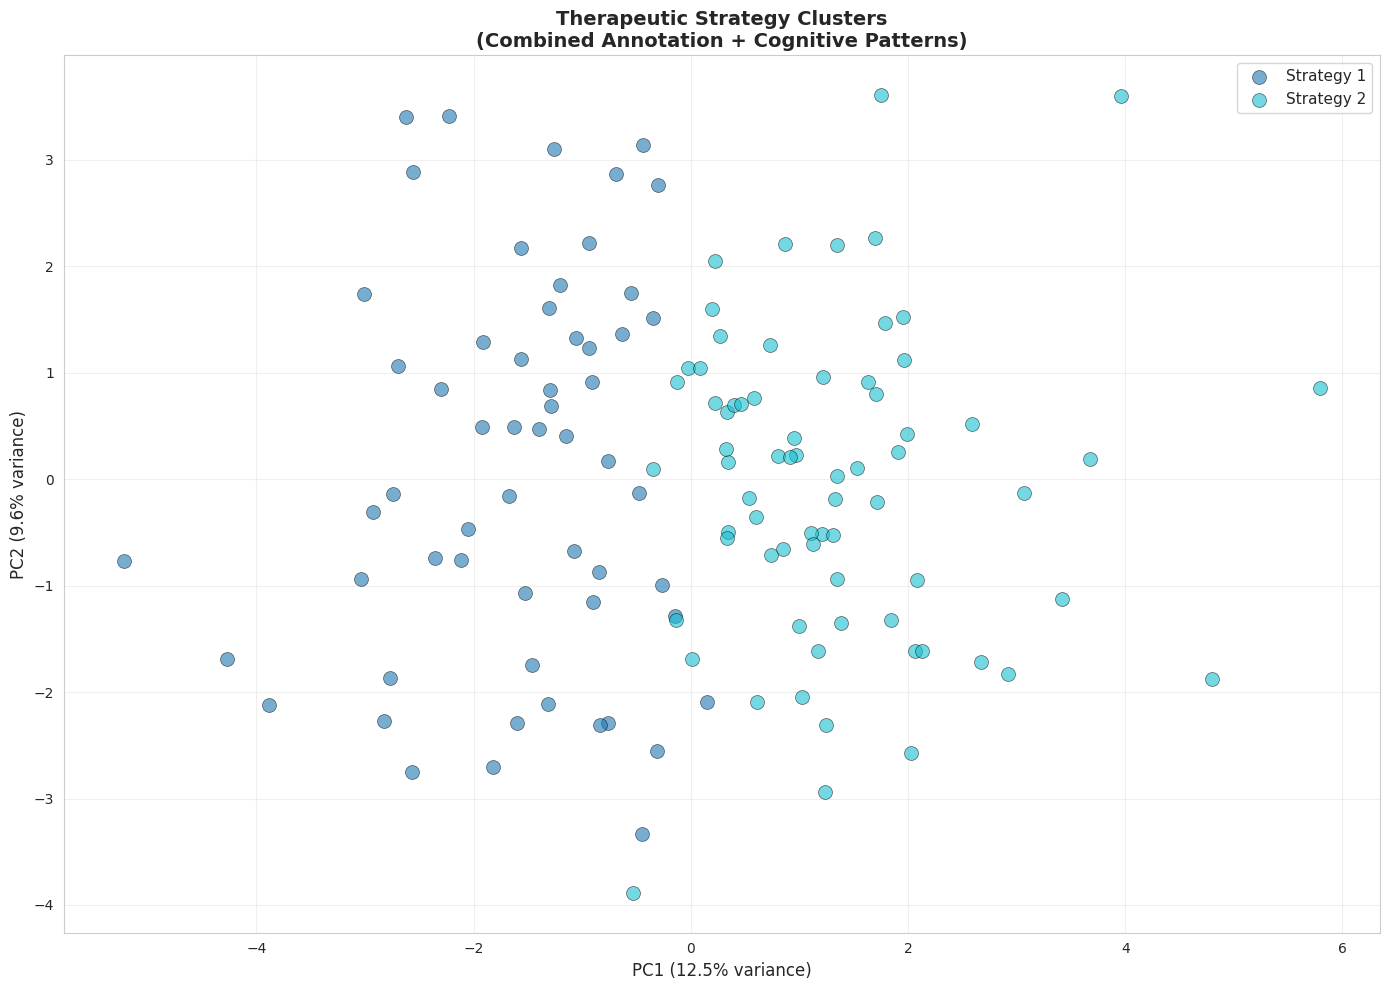

✅ Visualization saved: output/analysis_AnnoMI/full_viz_2_strategy_clusters.png


In [10]:
# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
profiles_df['pca_x'] = X_pca[:, 0]
profiles_df['pca_y'] = X_pca[:, 1]

fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    cluster_df = profiles_df[profiles_df['cluster'] == cluster_id]
    ax.scatter(cluster_df['pca_x'], cluster_df['pca_y'], 
               c=[colors[cluster_id]], s=100, alpha=0.6,
               edgecolors='black', linewidths=0.5,
               label=f'Strategy {cluster_id + 1}')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Therapeutic Strategy Clusters\n(Combined Annotation + Cognitive Patterns)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/full_viz_2_strategy_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/full_viz_2_strategy_clusters.png")

## 7️⃣ Analysis 5: Cross-modal Transition Analysis

How do annotation behaviors and cognitive actions flow together?

In [11]:
print("="*80)
print("CROSS-MODAL TRANSITION ANALYSIS")
print("="*80)

# Create simplified behavior labels
def get_behavior_label(row):
    if row['interlocutor'] != 'therapist':
        return 'client'
    
    if row['reflection_exists'] == True:
        return f"reflect_{row['reflection_subtype']}"
    elif row['question_exists'] == True:
        return f"question_{row['question_subtype']}"
    elif row['therapist_input_exists'] == True:
        return "input"
    else:
        return "other"

df_work['behavior_label'] = df_work.apply(get_behavior_label, axis=1)

# Analyze transitions
behavior_transitions = Counter()

for transcript_id in df_work['transcript_id'].unique():
    transcript_df = df_work[df_work['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    for i in range(len(transcript_df) - 1):
        current_behavior = transcript_df.iloc[i]['behavior_label']
        next_behavior = transcript_df.iloc[i+1]['behavior_label']
        behavior_transitions[(current_behavior, next_behavior)] += 1

print("\nTOP 20 BEHAVIOR TRANSITIONS:")
print("-" * 80)
for i, ((b1, b2), count) in enumerate(behavior_transitions.most_common(20), 1):
    print(f"{i:2d}. {b1:25s} → {b2:25s} ({count:4d} times)")

# Save results
transitions_df = pd.DataFrame(
    [(b1, b2, count) for (b1, b2), count in behavior_transitions.items()],
    columns=['from_behavior', 'to_behavior', 'count']
)
transitions_df.to_csv('output/analysis_AnnoMI/full_behavior_transitions.csv', index=False)
print("\n✅ Transitions saved: output/analysis_AnnoMI/full_behavior_transitions.csv")

CROSS-MODAL TRANSITION ANALYSIS

TOP 20 BEHAVIOR TRANSITIONS:
--------------------------------------------------------------------------------
 1. client                    → client                    ( 939 times)
 2. question_open             → client                    ( 733 times)
 3. client                    → reflect_simple            ( 570 times)
 4. client                    → reflect_complex           ( 529 times)
 5. client                    → question_open             ( 497 times)
 6. reflect_simple            → client                    ( 474 times)
 7. reflect_complex           → client                    ( 451 times)
 8. question_closed           → client                    ( 421 times)
 9. client                    → other                     ( 364 times)
10. client                    → question_closed           ( 354 times)
11. client                    → input                     ( 311 times)
12. other                     → client                    ( 311 times)
13. i

## 8️⃣ Summary and Export

In [ ]:
print("="*80)
print("COMPREHENSIVE SUMMARY - FULL DATASET ANALYSIS")
print("="*80)

summary = {
    'dataset': {
        'total_utterances': len(df_work),
        'transcripts': int(df_work['transcript_id'].nunique()),
        'topics': int(df_work['topic'].nunique()),
        'therapist_utterances': len(df_work[df_work['interlocutor'] == 'therapist']),
        'client_utterances': len(df_work[df_work['interlocutor'] == 'client']),
    },
    'annotation_subtypes': {
        'therapist_input': dict(input_subtypes),
        'reflection': dict(reflection_subtypes),
        'question': dict(question_subtypes),
    },
    'cognitive_actions': {
        'mean_per_utterance': float(df_work['num_active_actions'].mean()),
        'median_per_utterance': float(df_work['num_active_actions'].median()),
    },
    'therapeutic_strategies': {
        'num_clusters': int(optimal_k),
        'cluster_sizes': [int((profiles_df['cluster'] == i).sum()) 
                         for i in range(optimal_k)],
    },
    'top_patterns': [
        pattern for pattern in pattern_counts.head(10).index.tolist()
    ],
}

# Save summary
with open('output/analysis_AnnoMI/full_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Summary saved: output/analysis_AnnoMI/full_analysis_summary.json")
print("\n" + "="*80)
print("ALL ANALYSES COMPLETE!")
print("="*80)
print("\nGenerated outputs:")
print("   1. full_viz_1_reflection_types.png")
print("   2. full_viz_2_strategy_clusters.png")
print("   3. full_behavior_transitions.csv")
print("   4. full_analysis_summary.json")